# MLOps Exercise: Medical Image Classification with Chest X-Ray Images

## Introduction

In this exercise, you'll gain practical experience with MLOps (Machine Learning Operations) by working on a real-world problem: classifying chest X-ray images to diagnose pneumonia. You'll go through various stages, from data cleaning to deployment, learning how to manage an end-to-end machine learning pipeline.

### Prerequisites

- Basic understanding of Python
- Familiarity with machine learning concepts
- Experience with Jupyter Notebooks

### Tools and Libraries

- Python
- NumPy
- OpenCV
- TensorFlow/Keras
- scikit-learn
- Flask
- Matplotlib
- imbalanced-learn

These libraries should cover most requirements for this exercise, including data manipulation (NumPy, pandas), visualization (Matplotlib), machine learning (scikit-learn, TensorFlow), image processing (OpenCV), and class imbalance treatment (imbalanced-learn).

### Table of Contents

1. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
2. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
3. [Class Imbalance](#Class-Imbalance)
4. [Model Building](#Model-Building)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Evaluation](#Model-Evaluation)
7. [Model Deployment (Bonus)](#Model-Deployment-(Bonus))


## Environment Setup

Before we begin, let's set up the environment. We'll install the necessary Python packages for this exercise.

```bash
pip install numpy pandas opencv-python matplotlib scikit-learn tensorflow flask
```

You can also create a `requirements.txt` file with the above packages and install them using `pip install -r requirements.txt`.
Be aware that you should download ipykernel and export your env to the jupyter notebook.
```bash
python -m ipykernel install --user --name=my_new_env
```

## Data Loading and Cleaning

### Objective

Load the dataset and clean it by removing corrupted images.

### Guidance

1. Download the Chest X-Ray Images (Pneumonia) dataset and place it in a directory accessible by this notebook. From https://ametice.univ-amu.fr
2. Unzip the dataset and explore its directory structure.
3. Load the images and labels for training.
4. Write a function to scan for and remove any corrupted or invalid images.

### Exercise

Now, load the dataset use the zipfile library and clean it by removing corrupted images. Write your code in the cell below.

```python
import zipfile

zip_file_path = 'path/to/your/zip/file.zip'
extract_path = 'path/to/extract/folder'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
```

After extracting, your dataset should have the following folder structure:

```
/
|-- test/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- train/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- val/
    |-- NORMAL/
    |-- PNEUMONIA/
```

You can point `train_path` and `test_path` to the `train` and `test` folders inside this extracted directory

In [1]:
zip_file_path = r'C:\Users\rayan\Downloads\Dataset.zip'
extract_path = r'C:\Users\rayan\Downloads\dataset'

In [4]:
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def loadingData(train_path, val_path, batch_size=32, target_size=(128, 128)):
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_generator = datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    val_generator = datagen.flow_from_directory(
        val_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, val_generator

In [3]:
from PIL import Image

def scanImages(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupted image: {image_path}")
                os.remove(image_path)

In [4]:
train_path = r'C:\Users\rayan\Downloads\dataset\chest_xray\train'
val_path = r'C:\Users\rayan\Downloads\dataset\chest_xray\val'
train_generator, val_generator = loadingData(train_path, val_path)

scanImages(extract_path)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Exploratory Data Analysis (EDA)

### Objective

Understand the dataset's basic statistics and visualize the data.

### Guidance

1. Use matplotlib to visualize some sample images from each class.
2. Investigate the distribution of classes (Pneumonia/Normal).

### Exercise

Perform exploratory data analysis on the dataset. Write your code in the cell below.


In [5]:
import matplotlib.pyplot as plt

test_path = r'C:\Users\rayan\Downloads\dataset\chest_xray\test'

def visualize_samples(data_path, class_name, num_samples=4):
    class_path = os.path.join(data_path, class_name)
    class_images = os.listdir(class_path)[:num_samples]
    plt.figure(figsize=(12, 8))
    for i, image_name in enumerate(class_images):
        img = Image.open(os.path.join(class_path, image_name))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'{class_name} Sample {i + 1}')
        plt.axis('off')
    plt.show()

def class_distribution(data_path):
    classes = os.listdir(data_path)
    class_counts = [len(os.listdir(os.path.join(data_path, cls))) for cls in classes]
    plt.figure(figsize=(8, 6))
    plt.bar(classes, class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

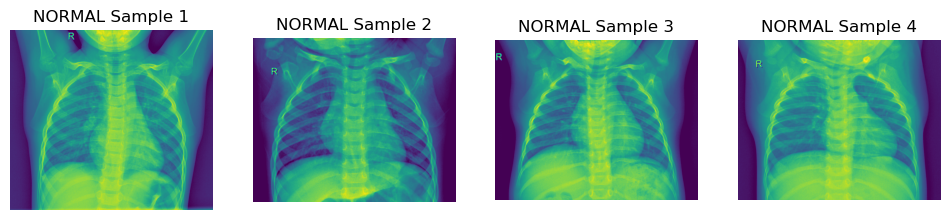

In [8]:
visualize_samples(train_path, 'NORMAL')

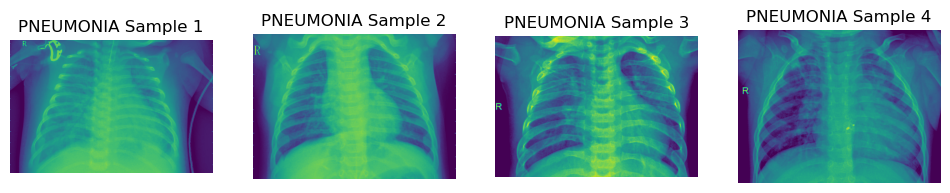

In [9]:
visualize_samples(train_path, 'PNEUMONIA')

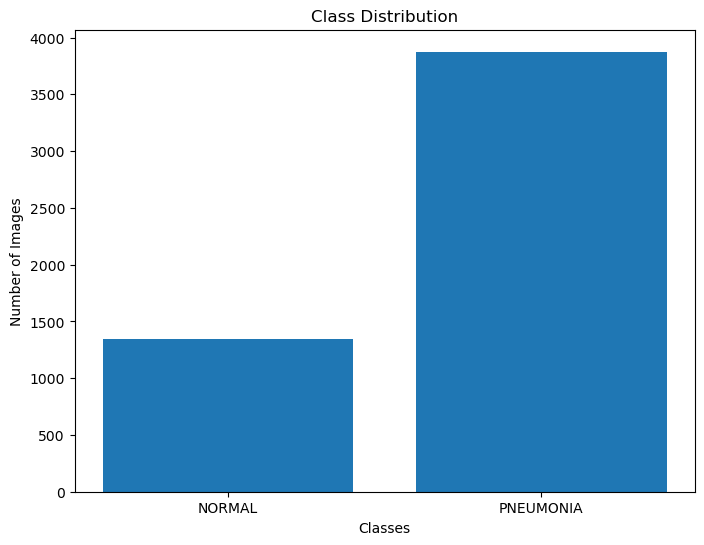

In [10]:
class_distribution(train_path)

## Class Imbalance

### Objective

Understand how class imbalance affects model performance and learn ways to mitigate it.

### Guidance

1. Train a baseline model without accounting for class imbalance.
2. Evaluate its performance using metrics like accuracy, precision, recall, and F1-score.
3. Experiment with techniques like class weighting or oversampling methods like SMOTE to balance the classes.

### Exercise

Address the class imbalance and evaluate the impact on the model. Write your code in the cell below.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification, so use sigmoid activation
])

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 3
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
)

^My kernel always dies here for some reason...

In [ ]:
from sklearn.metrics import classification_report

y_true = val_generator.classes
y_pred = model.predict(val_generator).round()

report = classification_report(y_true, y_pred)
print(report)

## Model Building

### Objective

Build and train a deep learning model for image classification.

### Guidance

1. Use a Convolutional Neural Network (CNN) for this task.
2. Experiment with different architectures and hyperparameters.

### Exercise

Build and train your model. Write your code in the cell below.


In [ ]:

# Your code here for Model Building


## Data Augmentation

### Objective

Improve your model's performance by using data augmentation techniques.

### Guidance

1. Apply data augmentation techniques like rotation, flipping, and zooming to generate more training data.
2. Retrain your model using the augmented dataset.

### Exercise

Apply data augmentation techniques and evaluate the impact on the model. Write your code in the cell below.


In [ ]:

# Your code here for Data Augmentation


## Model Evaluation

### Objective

Evaluate your model's performance using different metrics and visualization tools.

### Guidance

1. Use metrics like accuracy, precision, recall, and F1-score for evaluation.
2. Plot confusion matrices and ROC curves to visualize your model's performance.

### Exercise

Evaluate your model and interpret the results. Write your code in the cell below.


In [ ]:

# Your code here for Model Evaluation


## Model Deployment (Bonus)

### Objective

Learn the basics of deploying a machine learning model.

### Guidance

1. Save your trained model.
2. Use Flask to create a simple REST API to serve your model.

### Exercise

Deploy your model using Flask. Write your code in the cell below.


In [ ]:

# Your code here for Model Deployment (Bonus)



### Next Steps

1. Experiment with more advanced architectures and hyperparameters.
2. Deploy your model
3. Integrate your model into a web application or other services.
4. Learn more about MLOps best practices and tools.


